Dataset citation: Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, V2, doi: 10.17632/rscbjbr9sj.2

http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

### [Package load]

In [1]:
import torch
print('pytorch version: {}'.format(torch.__version__))

pytorch version: 2.2.2


In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
%matplotlib inline

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 2.2.2
GPU 사용 가능 여부: False


In [3]:
# 이걸 해줘야 matplotlib 시행 시 에러가 안 남
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### [For Colab]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path

folder = "인공지능 공부" # 상위 directory
project_dir = "[Kaggle] Retinal OCT Images (optical coherence tomography)제목없는 폴더" # 폴더 이름
base_path = Path("/content/drive/MyDrive/")
project_path = base_path / folder / project_dir

os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

### [Setting Hyperparameters]

In [4]:
batch_size = 64
num_epochs = 30
learning_rate = 0.001

### [Dataset & DataLoader]

- ##### 1 channel -> (1,224,224)

In [5]:
data_dir = '../data/OCT'  # 압축 해제된 데이터셋의 디렉토리 경로

# For Kaggle notebook
#data_dir = '/kaggle/input/kermany2018/OCT2017 /'

In [6]:
class OCTDataset(Dataset):
    def __init__(self, data_dir, mode, transform=None):
        self.all_data = sorted(glob.glob(os.path.join(data_dir, mode,'*', '*')))
        self.transform = transform
    
    def __getitem__(self, index):
        data_path = self.all_data[index]
        img = Image.open(data_path)
        if self.transform is not None:
            img = self.transform(img)
        name = os.path.basename(data_path)
        if name.startswith('NORMAL'):
            label = 0
        elif name.startswith('CNV'):
            label = 1
        elif name.startswith('DME'):
            label = 2
        elif name.startswith('DRUSEN'):
            label = 3
        return img, label
    
    def __len__(self):
        length = len(self.all_data)
        return length

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(0.1881,0.1850)
    ]),
    'val': transforms.Compose([
        transforms.Resize([256]),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(0.1881,0.1850)
    ])
}

In [ ]:
train_data = OCTDataset(data_dir=data_dir, mode='train', transform=data_transforms['train'])
val_data = OCTDataset(data_dir=data_dir, mode='val', transform=data_transforms['val'])
test_data = OCTDataset(data_dir=data_dir, mode='test', transform=data_transforms['val'])

In [ ]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=False)

In [ ]:
# Calculating mean and std of training data set
full_loader = DataLoader(train_data, shuffle=False) #num_workers=os.cpu_count())
mean = torch.zeros(1)
std = torch.zeros(1)
for inputs, _ in tqdm(full_loader):
    mean += inputs.mean()
    std += inputs.std()
mean /= len(train_data)
std /= len(train_data)
print(f"train mean: {mean}, train std: {std}")

  0%|          | 0/83484 [00:00<?, ?it/s]

train mean: tensor([0.1881]), train std: tensor([0.1850])


In [ ]:
train_mean = 0.1881
train_std = 0.1850

- ##### 3 channel: Input을 3번 concat -> (3,224,224)

In [8]:
data_dir = '../data/OCT'  # 압축 해제된 데이터셋의 디렉토리 경로

# For Kaggle notebook
#data_dir = '/kaggle/input/kermany2018/OCT2017 /'

In [9]:
class OCTDataset(Dataset):
    def __init__(self, data_dir, mode, transform=None):
        self.all_data = sorted(glob.glob(os.path.join(data_dir, mode,'*', '*')))
        self.transform = transform
    
    def __getitem__(self, index):
        data_path = self.all_data[index]
        img = Image.open(data_path)
        if self.transform is not None:
            img = self.transform(img)
        img = img.squeeze()
        img = torch.stack((img, img, img,), dim=0)  # VGG16이 3 channel이라 concat시키기
        name = os.path.basename(data_path)
        if name.startswith('NORMAL'):
            label = 0
        elif name.startswith('CNV'):
            label = 1
        elif name.startswith('DME'):
            label = 2
        elif name.startswith('DRUSEN'):
            label = 3
        return img, label
    
    def __len__(self):
        length = len(self.all_data)
        return length

In [10]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(0.1881,0.1850)
    ]),
    'val': transforms.Compose([
        transforms.Resize([256]),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(0.1881,0.1850)
    ])
}

In [11]:
train_data = OCTDataset(data_dir=data_dir, mode='train', transform=data_transforms['train'])
val_data = OCTDataset(data_dir=data_dir, mode='val', transform=data_transforms['val'])
test_data = OCTDataset(data_dir=data_dir, mode='test', transform=data_transforms['val'])

In [12]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=False)

In [13]:
train_mean = 0.1881
train_std = 0.1850

### [Model: DenseNet]

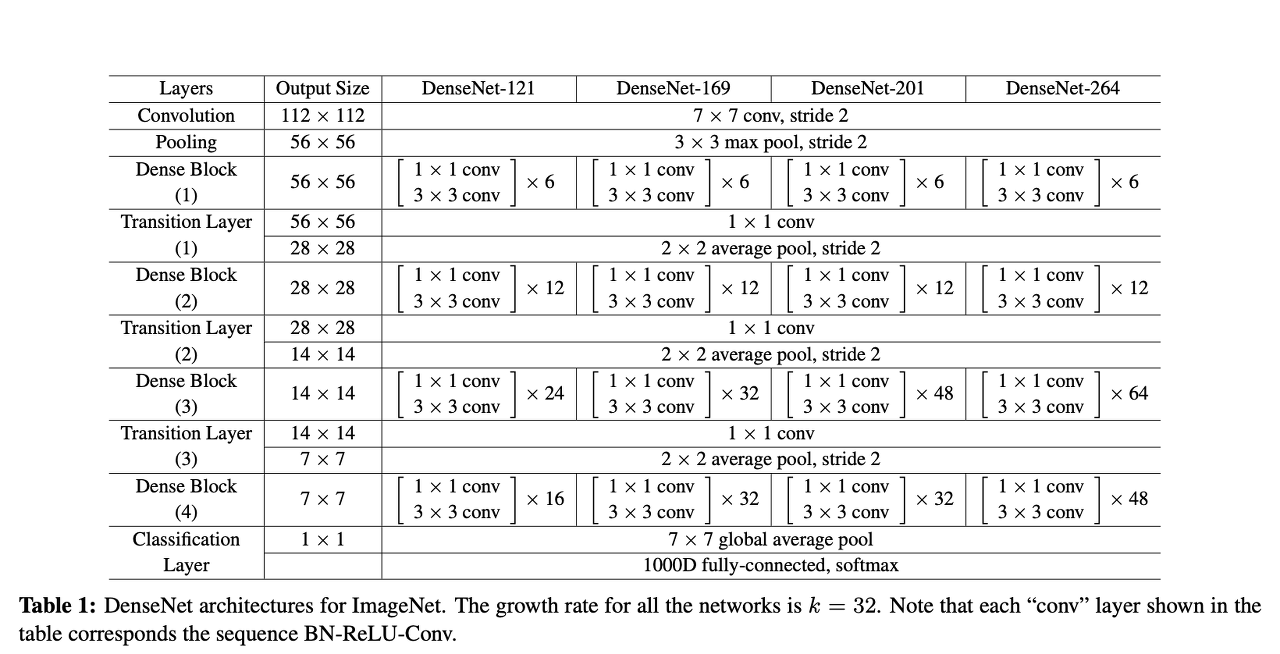

- https://github.com/pytorch/vision/blob/main/torchvision/models/densenet.py

In [14]:
class BottleneckLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, dropout_rate):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(num_input_features)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(num_input_features, bn_size*growth_rate, kernel_size=1, stride=1, bias=False)
            # num_input_features -> 1x1 conv -> bn_size*growth_rate로 channel 변경
        self.bn2 = nn.BatchNorm2d(bn_size*growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size*growth_rate, growth_rate, kernel_size=3, padding=1, stride=1, bias=False)
            # bn_size*growth_rate -> 3x3 conv -> growth_rate로 channel 변경

        self.dropout_rate = dropout_rate
    
    def forward(self, input):
        output = self.conv1(self.relu1(self.bn1(input)))
        output = self.conv2(self.relu2(self.bn2(output)))
        if self.dropout_rate>0:
            output = F.dropout(output, p=self.dropout_rate, training = self.training)
        output = torch.cat((input, output), 1)
        return output


class DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, growth_rate, bn_size, dropout_rate):
        super().__init__()
        for i in range(num_layers):
            layer = BottleneckLayer(num_input_features=num_input_features+i*growth_rate, growth_rate=growth_rate,
                                    bn_size=bn_size, dropout_rate=dropout_rate)
            self.add_module("denselayer%d" %(i+1), layer)
    
    def forward(self, x):
        for c in self.children():
            x = c(x)
        return x


class Transition(nn.Module):
    def __init__(self, num_input_features, theta=0.5):  # theta는 output channel을 얼마나 줄일지 정하는 hyperparameter
        super().__init__()
        self.bn = nn.BatchNorm2d(num_input_features)
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(num_input_features, int(num_input_features*theta), kernel_size=1, stride=1, bias=False)   # 1x1 conv
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
    
    def forward(self, input):
        output = self.pool(self.conv(self.relu(self.bn(input))))
        return output


'''처음 Conv (1) + 1st Denseblock (6*2 = 12) + Transition (1) + 2nd Denseblock (12*2 = 24) + Transition (1)
 + 3rd Denseblock (24*2 = 48) + Transition (1) + 4th Denseblock (16*2 = 32) + Classification (1) = 121 layer 
'''
from collections import OrderedDict

class DenseNet(nn.Module):
    def __init__(self, growth_rate=32,block_config=(6, 12, 24, 16),num_init_features=64,bn_size=4,theta=0.5,drop_rate=0,num_classes=1000):
        super().__init__()
        # 1st Conv
        self.features = nn.Sequential(
            OrderedDict(
                [
                    ("conv0", nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
                    ("norm0", nn.BatchNorm2d(num_init_features)),
                    ("relu0", nn.ReLU(inplace=True)),
                    ("pool0", nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
                ]
            )
        )

        # Denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = DenseBlock(num_layers=num_layers, num_input_features=num_features, growth_rate=growth_rate, bn_size=bn_size, dropout_rate=drop_rate)
            self.features.add_module("Denseblock%d"%(i+1), block)
            num_features = num_features + num_layers*growth_rate
            if i != len(block_config)-1:    #Denseblock 사이에 transition 끼워넣기
                transition = Transition(num_input_features=num_features, theta=theta)
                self.features.add_module("Transition%d" % (i + 1), transition)
                num_features = num_features // 2 #theta가 0.5기 때문

        # Final batch norm
        self.features.add_module("norm5", nn.BatchNorm2d(num_features))
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

In [15]:
densenet121 = DenseNet(num_classes=4).to(device)

In [16]:
densenet121

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (Denseblock1): DenseBlock(
      (denselayer1): BottleneckLayer(
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): BottleneckLayer(
        (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [17]:
temp = torch.Tensor(np.random.randint(1, 255, size=(1, 3, 224, 224)))
densenet121(temp)

tensor([[ 0.4987, -0.3693,  0.6487, -0.0810]], grad_fn=<AddmmBackward0>)

In [18]:
from torchsummary import summary
summary(densenet121, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]           8,192
       BatchNorm2d-8          [-1, 128, 56, 56]             256
              ReLU-9          [-1, 128, 56, 56]               0
           Conv2d-10           [-1, 32, 56, 56]          36,864
  BottleneckLayer-11           [-1, 96, 56, 56]               0
      BatchNorm2d-12           [-1, 96, 56, 56]             192
             ReLU-13           [-1, 96, 56, 56]               0
           Conv2d-14          [-1, 128,

In [19]:
from torchinfo import summary
summary(densenet121, input_size=(1, 3, 224, 224), col_width=20, depth=121, row_settings=["depth", "var_names"], col_names=["input_size", "kernel_size", "output_size", "params_percent"])

Layer (type (var_name):depth-idx)                       Input Shape          Kernel Shape         Output Shape         Param %
DenseNet (DenseNet)                                     [1, 3, 224, 224]     --                   [1, 4]                    --
├─Sequential (features): 1-1                            [1, 3, 224, 224]     --                   [1, 1024, 7, 7]           --
│    └─Conv2d (conv0): 2-1                              [1, 3, 224, 224]     [7, 7]               [1, 64, 112, 112]      0.14%
│    └─BatchNorm2d (norm0): 2-2                         [1, 64, 112, 112]    --                   [1, 64, 112, 112]      0.00%
│    └─ReLU (relu0): 2-3                                [1, 64, 112, 112]    --                   [1, 64, 112, 112]         --
│    └─MaxPool2d (pool0): 2-4                           [1, 64, 112, 112]    3                    [1, 64, 56, 56]           --
│    └─DenseBlock (Denseblock1): 2-5                    [1, 64, 56, 56]      --                   [1, 256, 56, 

### [Saving checkpoints]

In [20]:
def save_model(model, epoch, optimizer, epoch_loss, val_accuracy, saved_dir):
    os.makedirs(saved_dir, exist_ok=True)
    check_point = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss
    }
    val_accuracy = round(val_accuracy,1)
    file_name = str(f"ckpoint_{epoch+1}_{val_accuracy}%.pt")
    output_path = os.path.join(saved_dir, file_name)
    torch.save(check_point,output_path)

### [Loss tracker]

##### Visdom for local setting

In [ ]:
import visdom

vis = visdom.Visdom()
vis.close(env="main")

Setting up a new session...


''

In [ ]:
def loss_tracker(loss_plot, loss_value, num):
    '''num, loss_value, are Tensor'''
    vis.line(X=num,
             Y=loss_value,
             win = loss_plot,
             update='append'
             )

In [ ]:
loss_plt = vis.line(Y=torch.Tensor(1).zero_(),opts=dict(title='loss_tracker', legend=['loss'], showlegend=True))

##### Tensorboard

In [21]:
logs_base_dir = "./logs/logs_simple"
os.makedirs(logs_base_dir, exist_ok=True)

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(logs_base_dir)

### [Defining Train, Val, Test Function]

In [22]:
def train(num_epochs, model, data_loader, criterion, optimizer, scheduler, val_every, device, saved_dir, writer):
    print('Start training..')
    torch.cuda.empty_cache()
    best_loss = 9999999
    train_loss_list = []
    val_loss_list = []
    train_accuracy_list = []
    val_accuracy_list = []
    for epoch in tqdm(range(num_epochs), desc='epoch'):
        count = 0.0
        # running_loss = 0.0
        for i, (imgs, labels) in tqdm(enumerate(data_loader), desc="in epoch"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Saving train loss
            train_loss_list.append(loss.item())

            _, argmax = torch.max(outputs, 1)
            accuracy = (labels == argmax).float().mean()
            # Saving train accuracy
            train_accuracy_list.append(accuracy)

            if (i+1) % 30 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(
                    epoch+1, num_epochs, i+1, len(data_loader), loss.item(), accuracy.item() * 100))
                writer.add_scalar('Loss/Train', loss, i)
                writer.add_scalar('Accuracy/Train', accuracy, i)
            #if i % 30 == 29:
                #loss_tracker(loss_plt, torch.Tensor([running_loss/30]), torch.Tensor([i + epoch*len(trainloader) ]))
                #running_loss = 0.0
        if (epoch + 1) % val_every == 0:
            avrg_loss, val_accuracy = validation(epoch + 1, model, val_loader, criterion, device)
            # Saving validation loss and accuracy
            val_loss_list.append(avrg_loss)
            writer.add_scalar('Loss/Validation', avrg_loss, epoch+1)
            val_accuracy_list.append(val_accuracy)
            writer.add_scalar('Accuracy/Validation', val_accuracy, epoch+1)
            if avrg_loss < best_loss:
                print('Best performance at epoch: {}'.format(epoch + 1))
                print('Save model in', saved_dir)
                best_loss = avrg_loss
                save_model(model, epoch, optimizer, avrg_loss, val_accuracy, saved_dir)
                count = 0
            else:
                count += 1
                if count >= 10:
                    print('Best performance does not occur within 10 epochs. Early stopping!!')
                    scheduler.step()
                    writer.flush()
                    return train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list
            ''' Only for local setting
            loss_tracker(loss_plt, torch.Tensor([avrg_loss]), torch.Tensor([epoch]))'''
    scheduler.step()
    writer.flush()
    return train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list

In [23]:
def validation(epoch, model, data_loader, criterion, device):
    print('Start validation #{}'.format(epoch) )
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        total_loss = 0
        cnt = 0
        for i, (imgs, labels) in enumerate(data_loader):
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs,labels)
            
            total += imgs.size(0)
            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum().item()
            total_loss += loss
            cnt += 1
        avrg_loss = total_loss / cnt
        val_accuracy = correct / total * 100
        print('Validation #{}  Accuracy: {:.2f}%  Average Loss: {:.4f}'.format(epoch, val_accuracy, avrg_loss))
    model.train()
    return avrg_loss, val_accuracy

In [24]:
def test(model, data_loader, device):
    print('Start test..')
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (imgs, labels) in tqdm(enumerate(data_loader)):
            imgs, labels = imgs.to(device), labels.to(device)
            
            outputs = model(imgs)
            
            _, argmax = torch.max(outputs, 1)
            total += imgs.size(0)
            correct += (labels == argmax).sum().item()

        print('Test accuracy for {} images: {:.2f}%'.format(total, correct / total * 100))
    model.train()

### [Loss function, Optimizer, Directory for saving]

In [26]:
torch.manual_seed(7777)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(densenet121.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.00001)

val_every = 1
saved_dir = './saved'

### [Train]

In [ ]:
train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list = train(num_epochs, densenet121, train_loader, criterion, optimizer, scheduler, val_every, device, saved_dir, writer)

##### Visualizing train loss and accuracy

- With matplotlib in colab setting

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.ylabel('Loss')
plt.plot(train_loss_list, label = 'Train')
plt.plot(val_loss_list, label = 'Validation')
plt.subplot(1,2,2)
plt.ylabel('Accuracy')
plt.plot(train_accuracy_list, label = 'Train')
plt.plot(val_accuracy_list, label = 'Validation')
# plt.savefig('graph.png',facecolor = 'w')
plt.show()

- With Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir='./logs/logs_simple'

### [Test]

##### Loading best model

In [ ]:
densenet121_test = DenseNet().to(device) 
model_path = './saved/.pt'    # .pt 앞에 파일 이름 붙이기
checkpoint = torch.load(model_path, map_location=device)
state_dict = checkpoint['model_state_dict']
densenet121_test.load_state_dict(state_dict)
densenet121_test.eval()

##### Actual test

In [ ]:
with torch.no_grad():
    test(densenet121_test, test_loader, device)